In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from src.const import AUDIO_PATH, MAIN_LABELS, BATCH_SIZE, VALIDATION_SPLIT, SEED
from src.data_loader import load_data

import audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, OneOf

In [2]:
train_ds, val_ds = load_data()

Found 64727 files belonging to 11 classes.
Using 51782 files for training.
Using 12945 files for validation.


In [51]:
# main_file_count = 0
# unknown_file_count = 0
# for class_dir in os.listdir(AUDIO_PATH):
#     for file in os.listdir(os.path.join(AUDIO_PATH, class_dir)):
#         if class_dir in MAIN_LABELS:
#             main_file_count += 1
#         else:
#             unknown_file_count +=1

# print(f"Main files count: {main_file_count}")
# print(f"Unknown files count: {unknown_file_count}")

In [8]:
label_names = np.array(train_ds.class_names)
print("label names:", label_names)


label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10']


In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


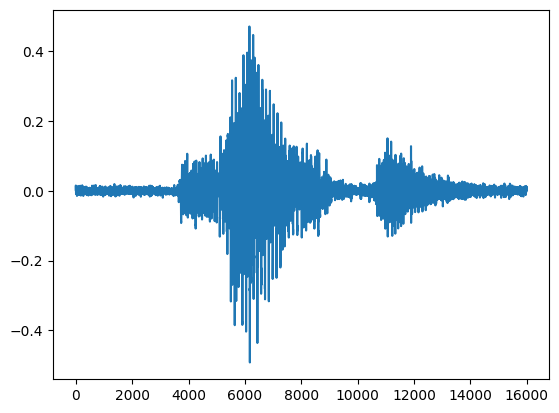

In [15]:
for X, y in train_ds.take(1):
    plt.plot(np.arange(0, len(X)), X.numpy())

In [16]:
audio = np.asarray(list(train_ds.map(lambda x, y: x)))
labels = np.asarray(list(train_ds.map(lambda x, y: y)))

In [187]:
augment = Compose(
    transforms= [
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
        TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        Shift(p=1, max_shift=0.2, min_shift=-0.2)
    ],
    shuffle=True
)

In [200]:
non_augmented = audio[0:3]
augmented = augment(samples=audio[0:3], sample_rate=16000)

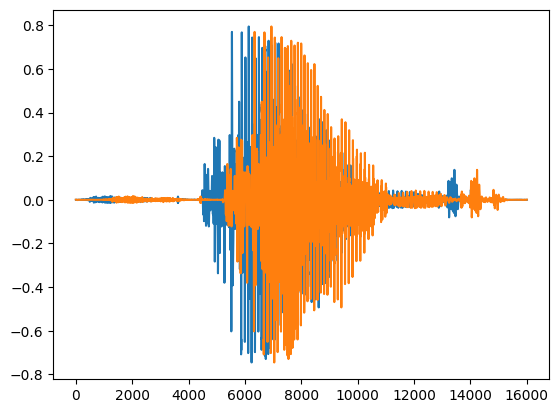

In [201]:
plt.plot(np.arange(0, len(non_augmented[1])), non_augmented[1])
plt.plot(np.arange(0, len(non_augmented[1])), augmented[1])

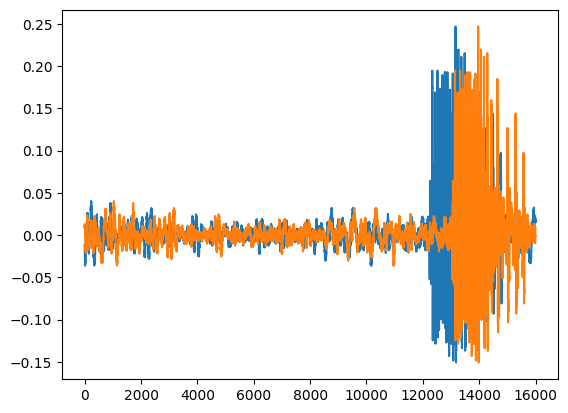

In [202]:
plt.plot(np.arange(0, len(non_augmented[1])), non_augmented[0])
plt.plot(np.arange(0, len(non_augmented[1])), augmented[0])

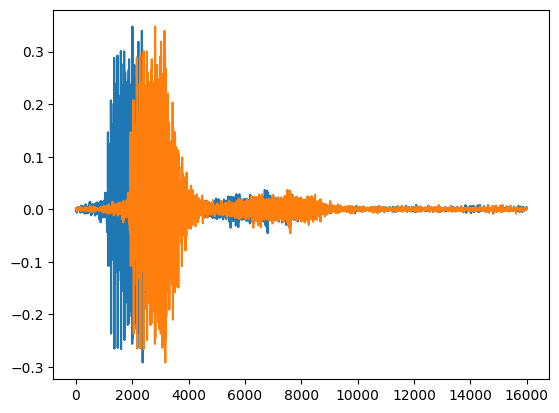

In [203]:
plt.plot(np.arange(0, len(non_augmented[1])), non_augmented[2])
plt.plot(np.arange(0, len(non_augmented[1])), augmented[2])

In [204]:
def preprocess_data_into_specs(ds):

  nfft=512
  window=512
  stride=256
  rate=16000
  mels=128
  fmin=0 
  fmax=8000
  top_db=80

  spect_ds = ds.map(
      map_func=lambda audio,label: (tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=stride), label),
      num_parallel_calls=tf.data.AUTOTUNE)
  mel_spect_ds = spect_ds.map(
    map_func=lambda audio, label: (tfio.audio.melscale(audio, rate=rate, mels=mels, fmin=fmin, fmax=fmax), label),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  return mel_spect_ds.map(
      map_func=lambda audio,label: (tfio.audio.dbscale(audio, top_db=top_db), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [10]:
spec_train_ds = preprocess_data_into_specs(train_ds)
spec_val_ds = preprocess_data_into_specs(val_ds)

In [ ]:
for example_spec_audio, example_spec_labels in spec_train_ds.take(10):
    print(example_spec_audio.shape)

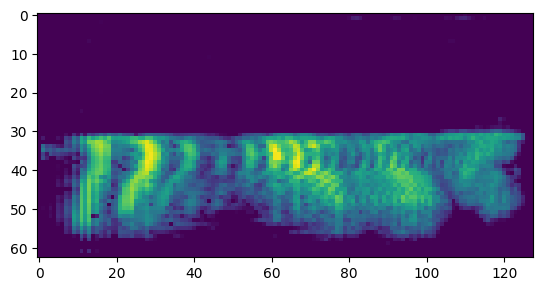

In [15]:
plt.imshow(example_spec_audio[39].numpy())
plt.show()

In [28]:
input_shape=(63,128)
model = tf.keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(11, activation='softmax'))
model.summary()

# layers.Bidirectional(layers.LSTM(20), merge_mode="sum")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,283 (555.79 KB)

 Trainable params: 142,283 (555.79 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
train_spectrogram_ds = spec_train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = spec_val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(train_spectrogram_ds, epochs=50, validation_data=val_spectrogram_ds)